# Imports

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

import scipy.optimize as sopt

tf.random.set_seed(1)

import numpy as np
import time
from pyDOE import lhs
import datetime

import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib widget

# Meta

In [2]:
__NAME = 'grif3ex4'
__CLASS = 'Laplace_Eqn'
__CACHE = None

In [34]:
__MODEL = "FFD"
# __MODEL = "Residual"

# Equation

In [35]:
V0 = 1.0

$$
\frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} = 0
$$

# Prepare data

In [36]:
# x : x
# y : y

In [37]:
lb = np.array([-1.0, 0.0])
ub = np.array([ 1.0, 1.0])

N_x = 400               # x
N_y = 200               # y
N_f = 20000             # Area
print(N_x, N_y, N_f)

x_data = np.linspace(lb[0], ub[0], N_x)[:, None]
y_data = np.linspace(lb[1], ub[1], N_y)[:, None]

400 200 20000


In [38]:
X_sol, Y_sol = np.meshgrid(x_data, y_data)

U_sol = np.hstack(
    (X_sol.flatten()[:, None], Y_sol.flatten()[:, None])
    )
# U_sol_star = U_sol.flatten()[:, None]

print(U_sol.shape, U_sol[0:10], sep='\n')

(80000, 2)
[[-1.          0.        ]
 [-0.99498747  0.        ]
 [-0.98997494  0.        ]
 [-0.98496241  0.        ]
 [-0.97994987  0.        ]
 [-0.97493734  0.        ]
 [-0.96992481  0.        ]
 [-0.96491228  0.        ]
 [-0.95989975  0.        ]
 [-0.95488722  0.        ]]


In [39]:
X_lb = np.hstack((X_sol[:, 0:1], Y_sol[:, 0:1]))        # left boundary
U_X_lb = np.repeat([[V0]], N_y, axis=0)

X_rb = np.hstack((X_sol[:, -1:], Y_sol[:, -1:]))        # right boundary
U_X_rb = np.repeat([[V0]], N_y, axis=0)

Y_lb = np.hstack((X_sol[0:1, :].T, Y_sol[0:1, :].T))    # lower boundary
U_Y_lb = np.repeat([[0]], N_x, axis=0)

Y_rb = np.hstack((X_sol[-1:, :].T, Y_sol[-1:, :].T))    # upper boundary
U_Y_rb = np.repeat([[0]], N_x, axis=0)

In [40]:
# shuffle boundary data
idx_X_lb = np.random.choice(y_data.shape[0], N_y, replace=False)
idx_X_rb = np.random.choice(y_data.shape[0], N_y, replace=False)
idx_Y_lb = np.random.choice(x_data.shape[0], N_x, replace=False)
idx_Y_rb = np.random.choice(x_data.shape[0], N_x, replace=False)

# X_lb = X_lb[idx_X_lb, :]
# X_rb = X_rb[idx_X_rb, :]
# Y_lb = Y_lb[idx_Y_lb, :]
# Y_rb = Y_rb[idx_Y_rb, :]

# U_X_lb = U_X_lb[idx_X_lb, :]
# U_X_rb = U_X_rb[idx_X_rb, :]
# U_Y_lb = U_Y_lb[idx_Y_lb, :]
# U_Y_rb = U_Y_rb[idx_Y_rb, :]

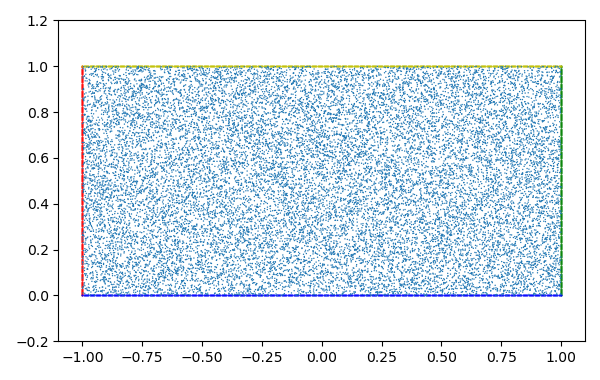

In [41]:
# lhs Sampling for the given domain
I_f = lb + (ub - lb) * lhs(2, N_f)

#-------------------------------------------------------------------------------
fig = plt.figure(figsize=(6, 3.8))
ax = fig.gca()

ax.set_xlim(lb[0] - 0.1, ub[0] + 0.1)
ax.set_ylim(lb[1] - 0.2, ub[1] + 0.2)

ax.scatter(X_lb[:, 0], X_lb[:, 1], s=1, c='r', marker='.', label='X_lb')
ax.scatter(X_rb[:, 0], X_rb[:, 1], s=1, c='g', marker='.', label='X_rb')
ax.scatter(Y_lb[:, 0], Y_lb[:, 1], s=1, c='b', marker='.', label='Y_lb')
ax.scatter(Y_rb[:, 0], Y_rb[:, 1], s=1, c='y', marker='.', label='Y_rb')

ax.scatter(I_f[:, 0], I_f[:, 1], s=4, marker='.', edgecolors='none')
plt.tight_layout()

# Model

In [42]:
class HiddenLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, units) -> None:
        super(HiddenLayer, self).__init__()
        xavier_stddev = np.sqrt(2 / (input_dim + units))
        w_init = tf.initializers.TruncatedNormal(stddev=xavier_stddev)
        self.w = tf.Variable(initial_value= w_init(shape= (input_dim, units), dtype= tf.float32), trainable= True)

        b_init = tf.zeros_initializer()
        self.b = tf.Variable(initial_value= b_init(shape= (1, units), dtype= tf.float32), trainable= True)

    def call(self, x):
        return tf.matmul(x, self.w) + self.b

In [43]:
class MySuperClass(tf.keras.Model):
    def __init__(self) -> None:
        super(MySuperClass, self).__init__()

    def initStitches(self):
        self.shapes = tf.shape_n(self.trainable_variables)
        self.n_tensors = len(self.shapes)

        # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
        # prepare required information first
        self.count = 0
        self.idx = [] # stitch indices
        self.part = [] # partition indices

        for i, shape in enumerate(self.shapes):
            n = np.product(shape)
            self.idx.append(tf.reshape(tf.range(self.count, self.count+n, dtype=tf.int32), shape))
            self.part.extend([i] * n)
            self.count += n

        self.part = tf.constant(self.part)

    def update(self, x : tf.Tensor):
        params = tf.dynamic_partition(x, self.part, self.n_tensors)
        for i, (shape, param) in enumerate(zip(self.shapes, params)):
            self.trainable_variables[i].assign(tf.reshape(param, shape))

In [44]:
class FeedForwardModel(MySuperClass):
    def __init__(self) -> None:
        super(FeedForwardModel, self).__init__()

        self.HLayer_1 = HiddenLayer(2, 50)
        self.HLayer_2 = HiddenLayer(50, 50)
        self.HLayer_3 = HiddenLayer(50, 50)
        self.HLayer_4 = HiddenLayer(50, 50)
        self.HLayer_5 = HiddenLayer(50, 50)
        self.HLayer_6 = HiddenLayer(50, 1)
        
        self.initStitches()

    def call(self, x):
        x = self.HLayer_1(x)
        x = tf.sin(x)
        x = self.HLayer_2(x)
        x = tf.sin(x)
        x = self.HLayer_3(x)
        x = tf.sin(x)
        x = self.HLayer_4(x)
        x = tf.sin(x)
        x = self.HLayer_5(x)
        x = tf.sin(x)
        x = self.HLayer_6(x)
        return x

In [45]:
class ResidualModel(MySuperClass):
    def __init__(self) -> None:
        super(ResidualModel, self).__init__()

        self.HLayer_1 = HiddenLayer(2, 50)
        self.HLayer_2 = HiddenLayer(50, 50)
        self.HLayer_3 = HiddenLayer(50, 50)
        self.HLayer_4 = HiddenLayer(50, 50)
        self.HLayer_5 = HiddenLayer(50, 50)
        self.HLayer_6 = HiddenLayer(50, 1)

        self.initStitches()

    def call(self, x):
        x = self.HLayer_1(x)
        x = tf.sin(x)

        x2 = x

        x = self.HLayer_2(x)

        x = x + x2
        x = tf.sin(x)
        x = self.HLayer_3(x)

        x = x + x2
        x = tf.sin(x)
        x = self.HLayer_4(x)

        x = x + x2
        x = tf.sin(x)
        x = self.HLayer_5(x)

        x = x + x2

        x = tf.sin(x)
        x = self.HLayer_6(x)
        return x

In [46]:
# Create an instance of the model
if (__MODEL == "FFD"):
    model = FeedForwardModel()
elif (__MODEL == "Residual"):
    model = ResidualModel()

# test
# x = tf.convert_to_tensor([[2.0, 0.0]])
# model(x)

In [47]:
if (__CACHE is None):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    __CACHE = tf.dynamic_stitch(model.idx, model.trainable_variables)
else:
    model.update(__CACHE)

## Training functions

In [48]:
lb_tf = tf.convert_to_tensor(lb, dtype=tf.float32)
ub_tf = tf.convert_to_tensor(ub, dtype=tf.float32)

X_lb_x_tf = tf.Variable(X_lb[:, 0:1], dtype=tf.float32)
X_lb_y_tf = tf.Variable(X_lb[:, 1:2], dtype=tf.float32)
U_X_lb_tf = tf.Variable(U_X_lb, dtype=tf.float32)

X_rb_x_tf = tf.Variable(X_rb[:, 0:1], dtype=tf.float32)
X_rb_y_tf = tf.Variable(X_rb[:, 1:2], dtype=tf.float32)
U_X_rb_tf = tf.Variable(U_X_rb, dtype=tf.float32)

Y_lb_x_tf = tf.Variable(Y_lb[:, 0:1], dtype=tf.float32)
Y_lb_y_tf = tf.Variable(Y_lb[:, 1:2], dtype=tf.float32)
U_Y_lb_tf = tf.Variable(U_Y_lb, dtype=tf.float32)

Y_rb_x_tf = tf.Variable(Y_rb[:, 0:1], dtype=tf.float32)
Y_rb_y_tf = tf.Variable(Y_rb[:, 1:2], dtype=tf.float32)
U_Y_rb_tf = tf.Variable(U_Y_rb, dtype=tf.float32)

x_f_tf = tf.Variable(I_f[:, 0:1], dtype=tf.float32)
y_f_tf = tf.Variable(I_f[:, 1:2], dtype=tf.float32)

In [49]:
def sol_net(x, y):
    print("Tracing sol_net_u")

    X = tf.concat([x, y], 1)
    H = 2.0 * (X - lb_tf) / (ub_tf - lb_tf) - 1.0
    u = model(H)
    return u

In [50]:
def sol_net_eqn(x, y):
    print("Tracing sol_net_f")
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x, y])

        with tf.GradientTape() as tape2:
            tape2.watch([x, y])
            u = sol_net(x, y)

        u_x, u_y = tape2.gradient(u, [x, y])

    u_xx = tape1.gradient(u_x, x)
    u_yy = tape1.gradient(u_y, y)

    del tape1

    f = u_xx + u_yy

    return f

In [51]:
def loss_gradients() -> tuple:
    print("Tracing loss_grad")
    with tf.GradientTape() as tape:
        tape.watch([X_lb_x_tf, X_lb_y_tf,               # left
                    X_rb_x_tf, X_rb_y_tf,               # right
                    Y_lb_x_tf, Y_lb_y_tf,               # bottom
                    Y_rb_x_tf, Y_rb_y_tf,               # right
                    x_f_tf, y_f_tf])            # domain sample

        # tf graphs for Solution
        U_X_lb_pred = sol_net(X_lb_x_tf, X_lb_y_tf)
        U_X_rb_pred = sol_net(X_rb_x_tf, X_rb_y_tf)
        U_Y_lb_pred = sol_net(Y_lb_x_tf, Y_lb_y_tf)
        U_Y_rb_pred = sol_net(Y_rb_x_tf, Y_rb_y_tf)
        U_pred = sol_net_eqn(x_f_tf, y_f_tf)

        # loss for Solution
        sol_loss = tf.reduce_sum(tf.square(U_X_lb_tf - U_X_lb_pred)) + \
                   tf.reduce_sum(tf.square(U_X_rb_tf - U_X_rb_pred)) + \
                   tf.reduce_sum(tf.square(U_Y_lb_tf - U_Y_lb_pred)) + \
                   tf.reduce_sum(tf.square(U_Y_rb_tf - U_Y_rb_pred)) + \
                   tf.reduce_sum(tf.square(U_pred))

    gradients = tape.gradient(sol_loss, model.trainable_variables)

    return sol_loss, gradients


# Training

## Adam Optimiizer

In [52]:
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [53]:
train_log_dir = 'R:/Tensorboard/{eqn}/{name}/{time}/{model}/'.format(
    eqn= __CLASS,
    name= __NAME,
    time= current_time,
    model= model.__class__.__name__
)

train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_log_dir

'R:/Tensorboard/Laplace_Eqn/grif3ex4/20220601-094802/FeedForwardModel/'

In [54]:
@tf.function
def train_adam():
    print("Tracing train_step")

    sol_loss, gradients = loss_gradients()

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(sol_loss)

train_adam()

Tracing train_step
Tracing loss_grad
Tracing sol_net_u
Tracing sol_net_u
Tracing sol_net_u
Tracing sol_net_u
Tracing sol_net_f
Tracing sol_net_u
Tracing train_step
Tracing loss_grad
Tracing sol_net_u
Tracing sol_net_u
Tracing sol_net_u
Tracing sol_net_u
Tracing sol_net_f
Tracing sol_net_u


In [55]:
EPOCHS = 2000

start_time = time.time()

for epoch in range(EPOCHS):

    train_adam()

    if (epoch % 10 == 0):

        print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        )

        with train_summary_writer.as_default():
            tf.summary.scalar('adam_loss', train_loss.result(), step=epoch)

    train_loss.reset_state()

elapsed = time.time() - start_time
print("Time :", elapsed)

Epoch 1, Loss: 481.1755676269531, 
Epoch 11, Loss: 310.02874755859375, 
Epoch 21, Loss: 272.8469543457031, 
Epoch 31, Loss: 267.4631652832031, 
Epoch 41, Loss: 267.14093017578125, 
Epoch 51, Loss: 267.00994873046875, 
Epoch 61, Loss: 266.8853454589844, 
Epoch 71, Loss: 266.8074645996094, 
Epoch 81, Loss: 266.7774963378906, 
Epoch 91, Loss: 266.7464904785156, 
Epoch 101, Loss: 266.716552734375, 
Epoch 111, Loss: 266.6874084472656, 
Epoch 121, Loss: 266.6575622558594, 
Epoch 131, Loss: 266.626953125, 
Epoch 141, Loss: 266.59490966796875, 
Epoch 151, Loss: 266.56048583984375, 
Epoch 161, Loss: 266.522705078125, 
Epoch 171, Loss: 266.480224609375, 
Epoch 181, Loss: 266.4310302734375, 
Epoch 191, Loss: 266.3721008300781, 
Epoch 201, Loss: 266.2989196777344, 
Epoch 211, Loss: 266.20391845703125, 
Epoch 221, Loss: 266.07440185546875, 
Epoch 231, Loss: 265.8876647949219, 
Epoch 241, Loss: 265.60174560546875, 
Epoch 251, Loss: 265.13616943359375, 
Epoch 261, Loss: 264.3315124511719, 
Epoch 271,

## Scipy Optimize L-BFGS-B

In [56]:
@tf.function
def loss_grad_external(x : tf.Tensor):
    print("tracing loss_grad")

    model.update(x)

    loss, gradients = loss_gradients()

    grads = tf.dynamic_stitch(model.idx, gradients)

    return loss, grads

loss_grad_external(tf.dynamic_stitch(model.idx, model.trainable_variables))

tracing loss_grad
Tracing loss_grad
Tracing sol_net_u
Tracing sol_net_u
Tracing sol_net_u
Tracing sol_net_u
Tracing sol_net_f
Tracing sol_net_u


(<tf.Tensor: shape=(), dtype=float32, numpy=74.389015>,
 <tf.Tensor: shape=(10401,), dtype=float32, numpy=
 array([38.335342 ,  6.500503 , -4.0808005, ..., -4.9832954, -8.983732 ,
         2.065651 ], dtype=float32)>)

In [57]:
itr = 0
def train_sopt(x :np.ndarray) -> tuple:
    global itr

    itr += 1

    loss, grad = [vv.numpy().astype(np.float64) for vv in loss_grad_external(tf.constant(x, dtype=tf.float32))]
    
    if (itr % 10 == 0):
        print(f'Iteration {itr}, Loss: {loss:.4f}')
        with train_summary_writer.as_default():
            tf.summary.scalar('lfbfgs_loss', loss, step=itr)

    return (loss, grad)

train_sopt(tf.dynamic_stitch(model.idx, model.trainable_variables).numpy())

(74.3890151977539,
 array([38.33534241,  6.50050306, -4.08080053, ..., -4.98329544,
        -8.98373222,  2.06565094]))

In [58]:
res = sopt.minimize(train_sopt, x0= tf.dynamic_stitch(model.idx, model.trainable_variables).numpy(), jac= True, method= 'L-BFGS-B')
res

Iteration 10, Loss: 74.3763
Iteration 20, Loss: 74.2616
Iteration 30, Loss: 74.0511
Iteration 40, Loss: 73.8188
Iteration 50, Loss: 73.4195
Iteration 60, Loss: 73.1386
Iteration 70, Loss: 72.8515
Iteration 80, Loss: 72.3592
Iteration 90, Loss: 72.0520
Iteration 100, Loss: 71.8364
Iteration 110, Loss: 71.5526
Iteration 120, Loss: 71.2057
Iteration 130, Loss: 70.6903
Iteration 140, Loss: 70.5817
Iteration 150, Loss: 70.3735
Iteration 160, Loss: 69.9160
Iteration 170, Loss: 69.7983
Iteration 180, Loss: 69.6187
Iteration 190, Loss: 69.3651
Iteration 200, Loss: 69.1934
Iteration 210, Loss: 68.8390
Iteration 220, Loss: 68.6781
Iteration 230, Loss: 68.3262
Iteration 240, Loss: 68.1534
Iteration 250, Loss: 67.9683
Iteration 260, Loss: 67.8347
Iteration 270, Loss: 67.4975
Iteration 280, Loss: 67.2396
Iteration 290, Loss: 66.8627
Iteration 300, Loss: 66.6024
Iteration 310, Loss: 65.5890
Iteration 320, Loss: 64.4145
Iteration 330, Loss: 63.9534
Iteration 340, Loss: 63.7673
Iteration 350, Loss: 63

      fun: 36.49300003051758
 hess_inv: <10401x10401 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.12703323, -1.14398837, -0.68167192, ...,  0.02891636,
        1.02800035, -0.50538254])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 6002
      nit: 5466
     njev: 6002
   status: 0
  success: True
        x: array([-0.27315232,  0.34828303, -0.14099204, ...,  0.1815383 ,
        0.65131407,  0.09139202])

# Prediction

In [59]:
loss_gradients()[0]

Tracing loss_grad
Tracing sol_net_u
Tracing sol_net_u
Tracing sol_net_u
Tracing sol_net_u
Tracing sol_net_f
Tracing sol_net_u


<tf.Tensor: shape=(), dtype=float32, numpy=36.493>

In [60]:
I_sol_star = np.hstack((X_sol.flatten()[:, None], Y_sol.flatten()[:, None]))
U_sol_star = U_sol.flatten()[:, None]

# print(X_sol_star.shape, U_sol_star.shape, sep='\n')
# print(X_sol_star[0:10], U_sol_star[0:10], sep='\n')

In [61]:
u_pred = sol_net( tf.Variable(I_sol_star[:, 0:1], dtype=tf.float32),
                    tf.Variable(I_sol_star[:, 1:2], dtype=tf.float32))

Tracing sol_net_u


In [62]:
I_sol_star[:, 1].shape

(80000,)

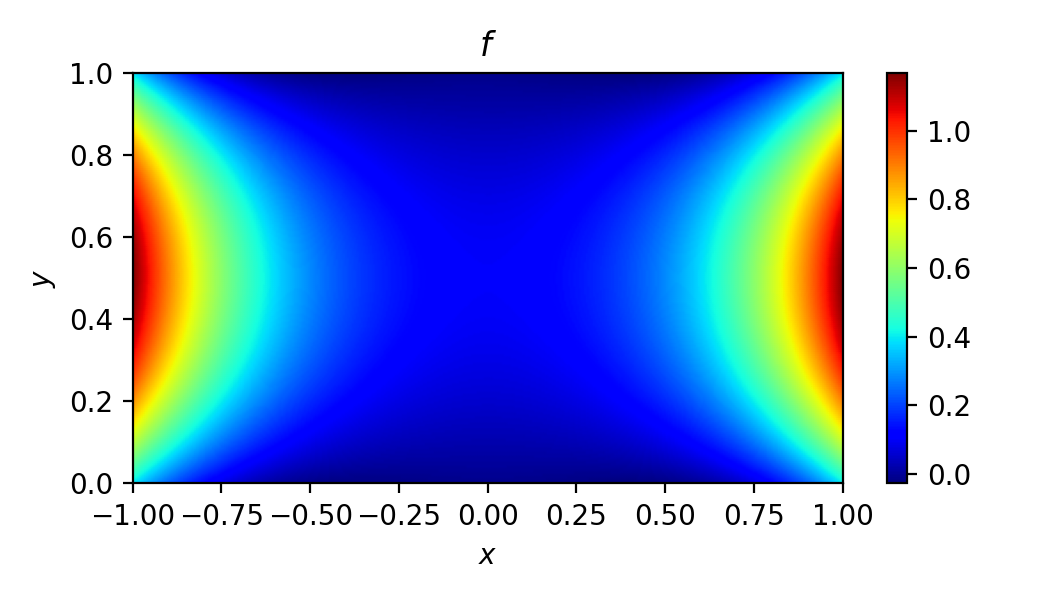

In [63]:
fig = plt.figure(figsize=(3*1.75,3), dpi=200)
ax = fig.subplots()

ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])

# plt.subplots_adjust(bottom=0.17)
# plt.subplots_adjust(left=0.17)

plt.title('$f$')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.pcolormesh(np.reshape(I_sol_star[:, 0], (N_y, -1)), 
               np.reshape(I_sol_star[:, 1], (N_y, -1)), 
               np.reshape(u_pred[:, 0], (N_y, -1)), 
               shading='gouraud',  cmap='jet')
plt.colorbar()

plt.tight_layout()

# plt.legend()

In [64]:
fig.savefig('../Figures/{name}-{model}.png'.format(
    eqn= __CLASS,
    name= __NAME,
    time= current_time,
    model= model.__class__.__name__
))